In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

batch_size = 32
shuffle_buffer_size = 1000

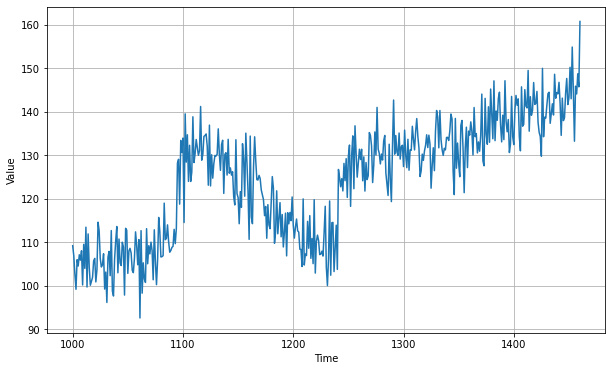

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
def windowed_dataset_expand_dims(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    return windowed_dataset(series, window_size, batch_size, shuffle_buffer)

In [8]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [9]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

baseline_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=["mae"])
baseline_model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 3739.3735 - mae: 47.2523
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 378.9617 - mae: 16.0322
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 243.2691 - mae: 12.5767
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 186.9902 - mae: 10.9675
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 130.6086 - mae: 8.8503
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 123.8936 - mae: 8.6151
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 102.9405 - mae: 7.9275
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 94.1118 - mae: 7.4183
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 90.3180 - mae: 7.2522
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 86.6659 - mae: 7.1076
Epoch 11/100
8/8 [==============================] - 0s 7

8/8 [==============================] - 0s 7ms/step - loss: 43.4607 - mae: 5.1402
Epoch 88/100
8/8 [==============================] - 0s 6ms/step - loss: 43.2059 - mae: 5.0893
Epoch 89/100
8/8 [==============================] - 0s 6ms/step - loss: 43.1936 - mae: 5.0917
Epoch 90/100
8/8 [==============================] - 0s 6ms/step - loss: 42.8965 - mae: 5.0780
Epoch 91/100
8/8 [==============================] - 0s 6ms/step - loss: 42.5755 - mae: 5.0844
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 43.1337 - mae: 5.0816
Epoch 93/100
8/8 [==============================] - 0s 7ms/step - loss: 42.5101 - mae: 5.0594
Epoch 94/100
8/8 [==============================] - 0s 7ms/step - loss: 42.4636 - mae: 5.0616
Epoch 95/100
8/8 [==============================] - 0s 6ms/step - loss: 42.3427 - mae: 5.0375
Epoch 96/100
8/8 [==============================] - 0s 6ms/step - loss: 42.3345 - mae: 5.0804
Epoch 97/100
8/8 [==============================] - 0s 6ms/step - loss: 4

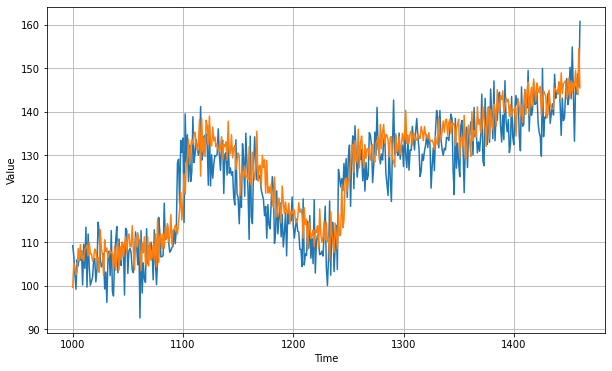

In [10]:
baseline_forecast = []
for time in range(len(series) - window_size):
    baseline_forecast.append(baseline_model.predict(series[time:time + window_size][np.newaxis]))

baseline_forecast = baseline_forecast[split_time-window_size:]
baseline_results = np.array(baseline_forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, baseline_results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, baseline_results).numpy()

5.3893137

In [12]:
window_size = 30
dataset = windowed_dataset_expand_dims(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [14]:
tuning_lr_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

tuning_lr_optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
tuning_lr_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuning_lr_optimizer,
              metrics=["mae"])
tuning_lr_history = tuning_lr_model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 32ms/step - loss: 66.9891 - mae: 67.4882
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 65.2296 - mae: 65.7286
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 63.6255 - mae: 64.1244
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 62.0183 - mae: 62.5171
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 60.1667 - mae: 60.6654
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 57.9962 - mae: 58.4948
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 55.5530 - mae: 56.0514
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 52.9202 - mae: 53.4185
Epoch 9/100
8/8 [==============================] - 0s 30ms/step - loss: 50.2578 - mae: 50.7556
Epoch 10/100
8/8 [==============================] - 0s 32ms/step - loss: 47.6421 - mae: 48.1398
Epoch 11/100
8/8 [==============================]

Epoch 87/100
8/8 [==============================] - 0s 62ms/step - loss: 10.8684 - mae: 11.3597
Epoch 88/100
8/8 [==============================] - 1s 65ms/step - loss: 12.4885 - mae: 12.9810
Epoch 89/100
8/8 [==============================] - 0s 31ms/step - loss: 15.3101 - mae: 15.8026
Epoch 90/100
8/8 [==============================] - 0s 30ms/step - loss: 15.7698 - mae: 16.2618
Epoch 91/100
8/8 [==============================] - 0s 33ms/step - loss: 31.5627 - mae: 32.0582
Epoch 92/100
8/8 [==============================] - ETA: 0s - loss: 26.5259 - mae: 27.022 - 0s 34ms/step - loss: 26.1393 - mae: 26.6357
Epoch 93/100
8/8 [==============================] - 0s 31ms/step - loss: 23.3375 - mae: 23.8338
Epoch 94/100
8/8 [==============================] - 0s 31ms/step - loss: 23.4176 - mae: 23.9141
Epoch 95/100
8/8 [==============================] - 0s 31ms/step - loss: 26.1566 - mae: 26.6523
Epoch 96/100
8/8 [==============================] - 0s 33ms/step - loss: 26.7077 - mae: 27.2035


(1e-08, 0.0001, 0.0, 30.0)

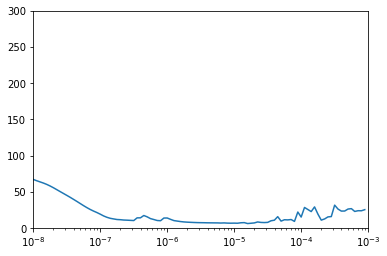

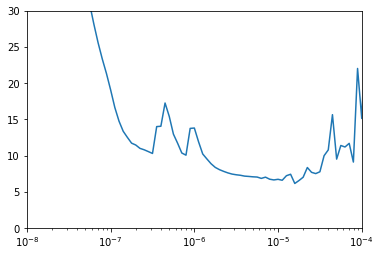

In [15]:
plt.semilogx(tuning_lr_history.history["lr"], tuning_lr_history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.figure()

plt.semilogx(tuning_lr_history.history["lr"], tuning_lr_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
tuned_lr_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

tuned_lr_optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
tuned_lr_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuned_lr_optimizer,
              metrics=["mae"])
tuned_lr_history = tuned_lr_model.fit(dataset,epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 34ms/step - loss: 20.6160 - mae: 21.1108
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 12.0723 - mae: 12.5627
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 9.5210 - mae: 10.0092
Epoch 4/500
8/8 [==============================] - 0s 32ms/step - loss: 8.6595 - mae: 9.1475
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 8.2549 - mae: 8.7407
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 7.2632 - mae: 7.7488
Epoch 7/500
8/8 [==============================] - 1s 95ms/step - loss: 6.6933 - mae: 7.1769
Epoch 8/500
8/8 [==============================] - 1s 104ms/step - loss: 6.3880 - mae: 6.8707
Epoch 9/500
8/8 [==============================] - 1s 127ms/step - loss: 6.1263 - mae: 6.6081
Epoch 10/500
8/8 [==============================] - 1s 101ms/step - loss: 6.0750 - mae: 6.5567
Epoch 11/500
8/8 [==============================] - 1s 110ms/

8/8 [==============================] - 0s 35ms/step - loss: 5.2830 - mae: 5.7647
Epoch 88/500
8/8 [==============================] - 0s 26ms/step - loss: 5.3836 - mae: 5.8640
Epoch 89/500
8/8 [==============================] - 0s 30ms/step - loss: 5.9043 - mae: 6.3869
Epoch 90/500
8/8 [==============================] - 0s 30ms/step - loss: 5.3163 - mae: 5.7966
Epoch 91/500
8/8 [==============================] - 0s 30ms/step - loss: 5.0458 - mae: 5.5248
Epoch 92/500
8/8 [==============================] - 0s 29ms/step - loss: 4.7226 - mae: 5.1997
Epoch 93/500
8/8 [==============================] - 0s 28ms/step - loss: 4.6609 - mae: 5.1397
Epoch 94/500
8/8 [==============================] - 0s 27ms/step - loss: 4.8434 - mae: 5.3225
Epoch 95/500
8/8 [==============================] - 0s 28ms/step - loss: 4.7685 - mae: 5.2460
Epoch 96/500
8/8 [==============================] - 0s 31ms/step - loss: 5.3113 - mae: 5.7930
Epoch 97/500
8/8 [==============================] - 0s 29ms/step - loss: 

8/8 [==============================] - 0s 50ms/step - loss: 5.1694 - mae: 5.6499
Epoch 174/500
8/8 [==============================] - 0s 55ms/step - loss: 4.7924 - mae: 5.2707
Epoch 175/500
8/8 [==============================] - 0s 56ms/step - loss: 4.8199 - mae: 5.2977
Epoch 176/500
8/8 [==============================] - 0s 57ms/step - loss: 5.2195 - mae: 5.7000
Epoch 177/500
8/8 [==============================] - 0s 33ms/step - loss: 4.7070 - mae: 5.1853
Epoch 178/500
8/8 [==============================] - 0s 26ms/step - loss: 4.9388 - mae: 5.4184
Epoch 179/500
8/8 [==============================] - 0s 28ms/step - loss: 4.6321 - mae: 5.1104
Epoch 180/500
8/8 [==============================] - 0s 27ms/step - loss: 4.5192 - mae: 4.9970
Epoch 181/500
8/8 [==============================] - 0s 26ms/step - loss: 4.7461 - mae: 5.2248
Epoch 182/500
8/8 [==============================] - 0s 27ms/step - loss: 4.9052 - mae: 5.3853
Epoch 183/500
8/8 [==============================] - 0s 29ms/ste

8/8 [==============================] - 0s 27ms/step - loss: 4.4268 - mae: 4.9038
Epoch 260/500
8/8 [==============================] - 0s 29ms/step - loss: 4.5301 - mae: 5.0085
Epoch 261/500
8/8 [==============================] - 0s 28ms/step - loss: 4.7607 - mae: 5.2392
Epoch 262/500
8/8 [==============================] - 0s 27ms/step - loss: 4.8456 - mae: 5.3247
Epoch 263/500
8/8 [==============================] - 0s 26ms/step - loss: 4.5850 - mae: 5.0603
Epoch 264/500
8/8 [==============================] - 0s 28ms/step - loss: 4.6153 - mae: 5.0926
Epoch 265/500
8/8 [==============================] - 0s 27ms/step - loss: 4.8031 - mae: 5.2815
Epoch 266/500
8/8 [==============================] - 0s 26ms/step - loss: 4.8204 - mae: 5.2993
Epoch 267/500
8/8 [==============================] - 0s 29ms/step - loss: 5.2424 - mae: 5.7234
Epoch 268/500
8/8 [==============================] - 1s 71ms/step - loss: 5.0133 - mae: 5.4939
Epoch 269/500
8/8 [==============================] - 1s 66ms/ste

8/8 [==============================] - 0s 52ms/step - loss: 5.1188 - mae: 5.5984
Epoch 346/500
8/8 [==============================] - 0s 44ms/step - loss: 5.2519 - mae: 5.7325
Epoch 347/500
8/8 [==============================] - 0s 28ms/step - loss: 4.9598 - mae: 5.4398
Epoch 348/500
8/8 [==============================] - 0s 28ms/step - loss: 4.6585 - mae: 5.1365
Epoch 349/500
8/8 [==============================] - 0s 30ms/step - loss: 4.5526 - mae: 5.0301
Epoch 350/500
8/8 [==============================] - 0s 27ms/step - loss: 4.6113 - mae: 5.0890
Epoch 351/500
8/8 [==============================] - 0s 28ms/step - loss: 4.5856 - mae: 5.0638
Epoch 352/500
8/8 [==============================] - 0s 27ms/step - loss: 4.7321 - mae: 5.2107
Epoch 353/500
8/8 [==============================] - 0s 31ms/step - loss: 4.7510 - mae: 5.2281
Epoch 354/500
8/8 [==============================] - 0s 29ms/step - loss: 4.5087 - mae: 4.9864
Epoch 355/500
8/8 [==============================] - 0s 53ms/ste

8/8 [==============================] - 0s 50ms/step - loss: 4.7975 - mae: 5.2776
Epoch 432/500
8/8 [==============================] - 0s 32ms/step - loss: 4.8603 - mae: 5.3385
Epoch 433/500
8/8 [==============================] - 0s 27ms/step - loss: 4.4973 - mae: 4.9741
Epoch 434/500
8/8 [==============================] - 0s 31ms/step - loss: 4.5051 - mae: 4.9833
Epoch 435/500
8/8 [==============================] - 0s 37ms/step - loss: 4.5387 - mae: 5.0161
Epoch 436/500
8/8 [==============================] - 0s 31ms/step - loss: 4.4927 - mae: 4.9712
Epoch 437/500
8/8 [==============================] - 0s 29ms/step - loss: 4.5620 - mae: 5.0414
Epoch 438/500
8/8 [==============================] - 0s 32ms/step - loss: 4.8452 - mae: 5.3237
Epoch 439/500
8/8 [==============================] - 0s 27ms/step - loss: 4.7442 - mae: 5.2241
Epoch 440/500
8/8 [==============================] - 0s 29ms/step - loss: 5.3270 - mae: 5.8082
Epoch 441/500
8/8 [==============================] - 0s 28ms/ste

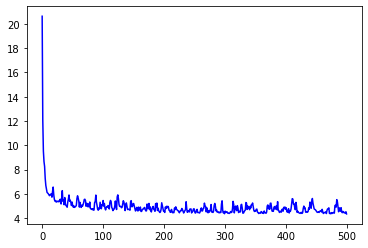

In [17]:
loss = tuned_lr_history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

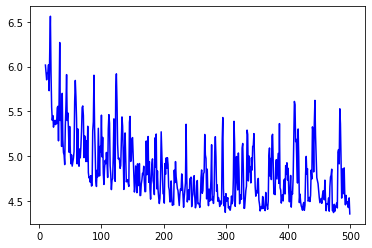

In [18]:
# Plot all but the first 10
loss = tuned_lr_history.history["loss"]
epochs = range(10, len(loss))
plt.plot(epochs, loss[10:], "b", label="Training Loss")
plt.show()

<Figure size 432x288 with 0 Axes>

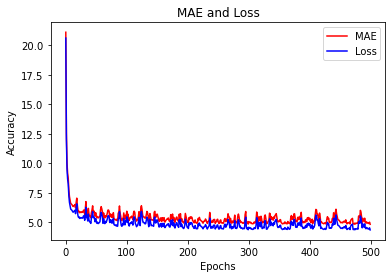

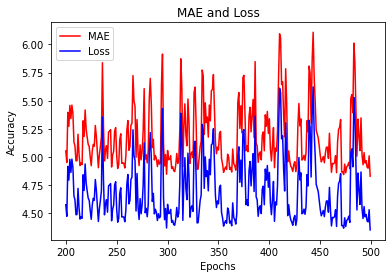

<Figure size 432x288 with 0 Axes>

In [19]:
mae = tuned_lr_history.history["mae"]
loss = tuned_lr_history.history["loss"]

mae_zoom = mae[200:]
loss_zoom = loss[200:]

epochs = range(len(loss)) # Get number of epochs
epochs_zoom = epochs[200:]

plt.plot(epochs, mae, "r")
plt.plot(epochs, loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()